In [3]:
import numpy as np
import torch
import os
from torchvision.io import read_image
from torchvision import datasets
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from torchvision import transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
torch.cuda.is_available()

False

In [6]:
torch.zeros((3,1)).T.cuda() @ torch.ones((3,1)).cuda()

AssertionError: Torch not compiled with CUDA enabled

In [7]:
class VIODataset(Dataset):
    def __init__(self, img_annot_file, data_dir, label_file):
        img_annot_cols=["stamp","name","none"]
        self.img_annot = pd.read_csv(img_annot_file, delimiter=' ', skiprows=1, names=img_annot_cols)
        self.img_annot = self.img_annot.iloc[: , :-1]

        label_cols=["stamp","tx","ty","tz","qx","qy","qz","qw","none"]
        self.labels = pd.read_csv(label_file, delimiter=' ', skiprows=1, names=label_cols)
        self.labels = self.labels.iloc[: , :-1]

        self.data_dir = data_dir
        self.transform = transforms.Compose([
            transforms.Normalize(mean=[.0], std=[.25]),
        ])

    def __len__(self):
        return len(self.img_annot)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.img_annot.iloc[idx]["name"])
        image = read_image(img_path).float()
        label = torch.tensor(self.labels.iloc[idx][["qx","qy","qz","qw"]].to_numpy(),
                             dtype=torch.float32)
        image = self.transform(image)
        return image, label

In [10]:
data_dir = "indoor_forward_3_snapdragon_with_gt/"
img_annot_cols=["stamp","name","none"]
img_annot = pd.read_csv(data_dir + "left_images.txt", delimiter=' ', skiprows=1, names=img_annot_cols)
img_annot = img_annot.iloc[: , :-1]
stereo_count = len(img_annot)
img_annot, len(img_annot), img_annot.iloc[0]["name"]

(            stamp                  name
 0     4878.802976     img/image_0_0.png
 1     4878.836147     img/image_0_1.png
 2     4878.869318     img/image_0_2.png
 3     4878.902451     img/image_0_3.png
 4     4878.935624     img/image_0_4.png
 ...           ...                   ...
 2547  4970.759446  img/image_0_2547.png
 2548  4970.792533  img/image_0_2548.png
 2549  4970.825706  img/image_0_2549.png
 2550  4970.858881  img/image_0_2550.png
 2551  4970.892067  img/image_0_2551.png
 
 [2552 rows x 2 columns],
 2552,
 'img/image_0_0.png')

In [11]:
label_cols=["stamp","tx","ty","tz","qx","qy","qz","qw","none"]
labels = pd.read_csv(data_dir + "groundtruth.txt", delimiter=' ', skiprows=1, names=label_cols)
labels = labels.iloc[: , :-1]
labels.iloc[0][["qx","qy","qz","qw"]], np.linalg.norm(labels.iloc[0][["qx","qy","qz","qw"]].to_numpy())

(qx    0.002119
 qy   -0.009726
 qz    0.902958
 qw   -0.429614
 Name: 0, dtype: float64,
 1.0000000000000004)

In [12]:
vio_dataset = VIODataset(data_dir + "left_images.txt", data_dir, data_dir + "groundtruth.txt")
vio_dataset.__getitem__(0)

(tensor([[[400., 400., 436.,  ..., 288., 296., 296.],
          [448., 444., 428.,  ..., 280., 288., 288.],
          [452., 452., 436.,  ..., 268., 264., 288.],
          ...,
          [244., 244., 216.,  ..., 184., 204., 208.],
          [220., 220., 220.,  ..., 176., 200., 196.],
          [196., 196., 232.,  ..., 184., 180., 196.]]]),
 tensor([ 0.0021, -0.0097,  0.9030, -0.4296]))

In [13]:
np.linalg.det(np.eye(3))

1.0

In [16]:
import transforms3d

In [17]:
alpha, beta, gamma = 0.123, -1.234, 2.345
origin, xaxis, yaxis, zaxis = [0, 0, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1]
R = transforms3d.euler.euler2mat(alpha, beta, gamma)
np.linalg.det(R) # this could be enforced in loss function ? : )

0.9999999999999999

In [18]:
# R = transforms3d.euler.euler2mat(alpha, beta, gamma)
R = np.random.rand(3,3)
R = torch.tensor(R, requires_grad=True)
Dloss = torch.norm(1 - R.det(),2)
Dloss.backward()

Dloss.item()

1.091546342973353

In [19]:
np.linalg.norm([0.00712511541035951,-0.00599798947503901,0.890495788939425,-0.45489614939434]) # quaternion sample

1.0

In [14]:
# data_dir = "indoor_forward_9_davis_with_gt/"
# colnames=["stamp","x","y","polarity"]
# my_data = pd.read_csv(data_dir + "events.txt", delimiter=' ', skiprows=1, names=colnames)
# events_count = len(my_data)
# my_data, len(my_data)
# events = my_data[['x','y','polarity']].to_numpy(), events_count/stereo_count, 256*256, events[:int(20e3)].shape

In [20]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18')
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) # multiple images?
model.fc = torch.nn.Linear(in_features=512, out_features=4, bias=True) # inly quaternion
model

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to C:\Users\Mads/.cache\torch\hub\v0.10.0.zip


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
input_image = Image.open("indoor_forward_3_snapdragon_with_gt/img/image_0_4.png") # gray scale
(w,h) = input_image.size
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.0], std=[.25]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# # move the input and model to GPU for speed if available
# if torch.cuda.is_available():
#     input_batch = input_batch.to('cuda')
#     model.to('cuda')

with torch.no_grad():
    output = model(input_batch)

# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)

tensor([ 0.1806,  0.4886, -0.2696,  0.5980])
tensor([0.2214, 0.3013, 0.1412, 0.3361])


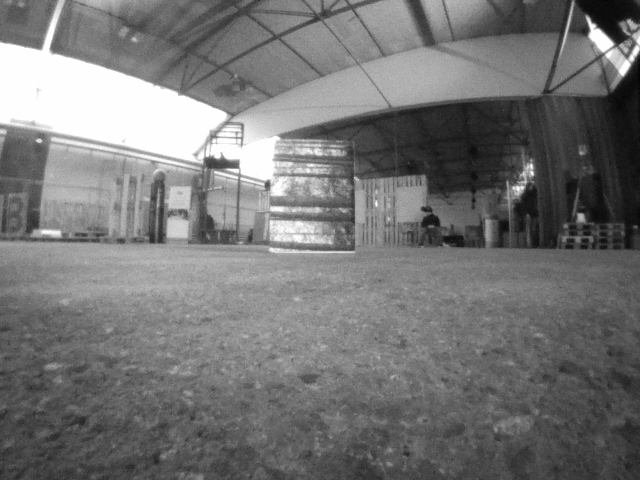

In [22]:
input_image

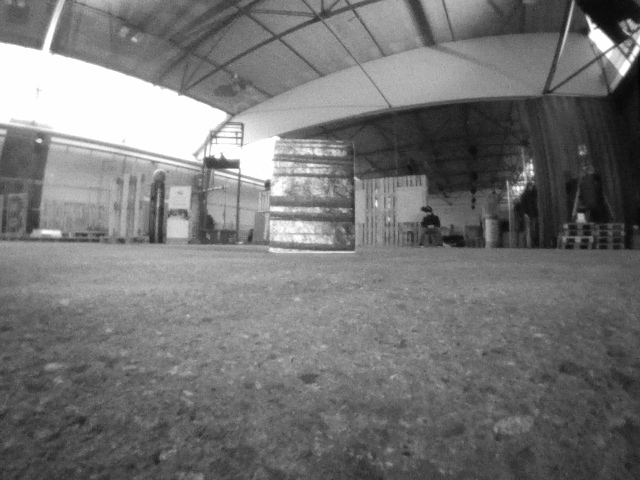

In [25]:
input_image = Image.open("indoor_forward_3_snapdragon_with_gt/img/image_0_0.png") # gray scale
input_image

In [26]:
model = model.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
dataloader = torch.utils.data.DataLoader(vio_dataset, batch_size=16, shuffle=True, num_workers=8)
next(iter(dataloader))

In [20]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html training loop from here

num_epochs = 5
for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    # for phase in ['train', 'val']:
    for phase in ['train']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0

        # Iterate over data.
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                qnorm = torch.norm(outputs,dim=1) # second part of the loss drives quaternion to be normalized i.e. norm(q) == 1
                loss = criterion(outputs, labels) + criterion(qnorm, torch.ones_like(qnorm))

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(vio_dataset)

        print(f'{phase} Loss: {epoch_loss:.4f}')

Epoch 0/4
----------
train Loss: 0.1358
Epoch 1/4
----------
train Loss: 0.0806
Epoch 2/4
----------
train Loss: 0.0599
Epoch 3/4
----------
train Loss: 0.0419
Epoch 4/4
----------
train Loss: 0.0355


In [31]:
pred = (np.ones((4,1)) - .1) 
pred = pred / np.linalg.norm(pred)
label = pred - .02 # 2e-2 error per example : )
np.linalg.norm(pred-label)

0.040000000000000036

In [4]:
def preprocess_images():
    data_dir = "indoor_forward_3_snapdragon_with_gt/"
    img_annot_cols=["stamp","name","none"]
    left_images = pd.read_csv(data_dir + "left_images.txt", delimiter=' ', skiprows=1, names=img_annot_cols)
    right_images = pd.read_csv(data_dir + "right_images.txt", delimiter=' ', skiprows=1, names=img_annot_cols)
    concatted_images = []

    for i in zip(left_images['name'], right_images['name']):
        print(i)
        left_image = Image.open(data_dir + i[0])
        right_image = Image.open(data_dir +  i[1])
        left_image = left_image.resize((160,120))
        right_image = right_image.resize((160,120))
        concat = Image.new('RGB', (left_image.width + right_image.width, left_image.height))
        concat.paste(left_image, (0,0))
        concat.paste(right_image, (left_image.width,0))
        concatted_images.append(concat)
    return concatted_images
test = preprocess_images()
print(len(test))

('img/image_0_0.png', 'img/image_1_0.png')
('img/image_0_1.png', 'img/image_1_1.png')
('img/image_0_2.png', 'img/image_1_2.png')
('img/image_0_3.png', 'img/image_1_3.png')
('img/image_0_4.png', 'img/image_1_4.png')
('img/image_0_5.png', 'img/image_1_5.png')
('img/image_0_6.png', 'img/image_1_6.png')
('img/image_0_7.png', 'img/image_1_7.png')
('img/image_0_8.png', 'img/image_1_8.png')
('img/image_0_9.png', 'img/image_1_9.png')
('img/image_0_10.png', 'img/image_1_10.png')
('img/image_0_11.png', 'img/image_1_11.png')
('img/image_0_12.png', 'img/image_1_12.png')
('img/image_0_13.png', 'img/image_1_13.png')
('img/image_0_14.png', 'img/image_1_14.png')
('img/image_0_15.png', 'img/image_1_15.png')
('img/image_0_16.png', 'img/image_1_16.png')
('img/image_0_17.png', 'img/image_1_17.png')
('img/image_0_18.png', 'img/image_1_18.png')
('img/image_0_19.png', 'img/image_1_19.png')
('img/image_0_20.png', 'img/image_1_20.png')
('img/image_0_21.png', 'img/image_1_21.png')
('img/image_0_22.png', 'img/im

In [6]:
test[0:3]

[<PIL.Image.Image image mode=RGB size=320x120>,
 <PIL.Image.Image image mode=RGB size=320x120>,
 <PIL.Image.Image image mode=RGB size=320x120>]

In [7]:
def stack_images(images):

    tensors = []
    convert_tensor = transforms.ToTensor()
    for i, v in enumerate(images):
        print(i)
        tensors.append(convert_tensor(v))

    output = []
    for i in range(2, len(tensors)):
        print(i)
        output.append(torch.stack(tensors[i-2:i+1]))

    return output


tensors = stack_images(test)

KeyboardInterrupt: 

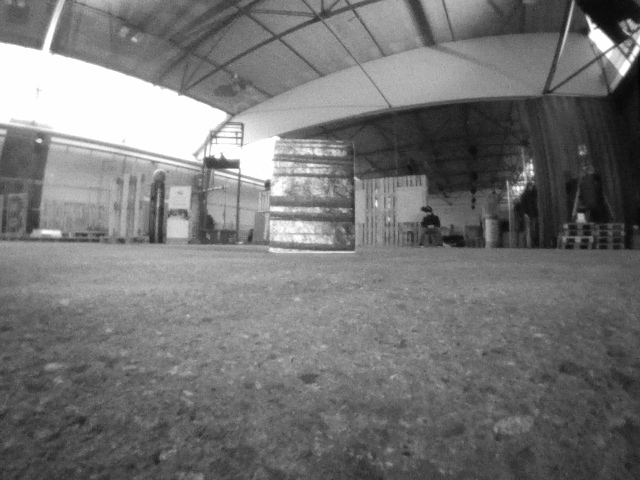

In [9]:
li